In [ ]:
!pip install -q transformers==4.38.2 datasets torch seaborn

In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dataset = load_dataset("imdb")

train_ds = dataset["train"].shuffle(seed=42).select(range(4000))
val_ds   = dataset["test"].select(range(1000))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Using device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [ ]:
def encode_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_enc = train_ds.map(encode_batch, batched=True)
val_enc   = val_ds.map(encode_batch, batched=True)

train_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
train_loader = DataLoader(train_enc, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_enc, batch_size=8)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
epochs = 5

train_losses = []
val_accuracies = []

In [ ]:
for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # ----- Validation -----
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    val_accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.4f}")


===== Epoch 1/5 =====
Training Loss: 0.3656
Validation Accuracy: 0.8620

===== Epoch 2/5 =====
Training Loss: 0.1557
Validation Accuracy: 0.8000

===== Epoch 3/5 =====
Training Loss: 0.0794
Validation Accuracy: 0.9200

===== Epoch 4/5 =====
Training Loss: 0.0575
Validation Accuracy: 0.8790

===== Epoch 5/5 =====
Training Loss: 0.0366
Validation Accuracy: 0.9240


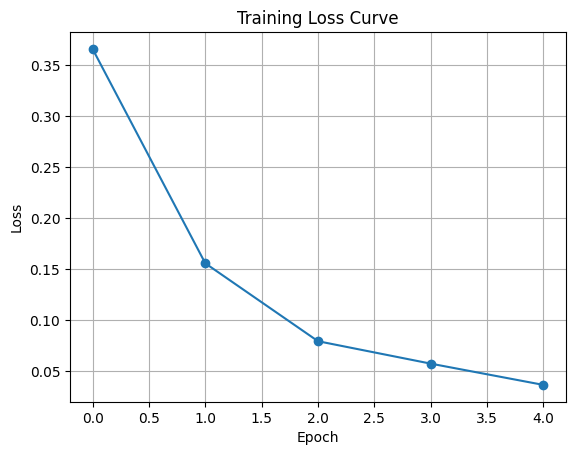

In [ ]:
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

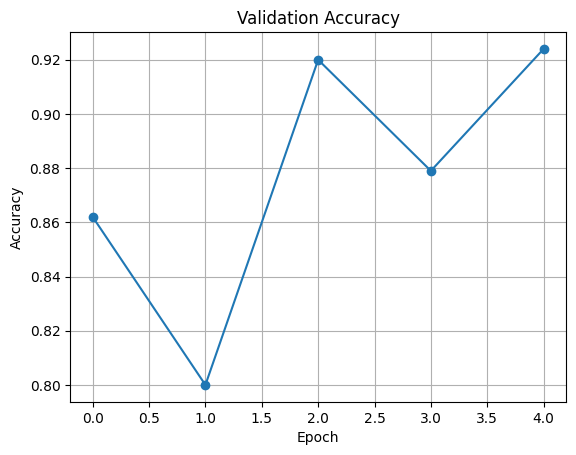

In [ ]:
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
def predict(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

    return "Positive" if pred == 1 else "Negative"

print(predict("This movie was absolutely amazing!"))
print(predict("This film is boring and a waste of time."))

Positive
Negative


In [ ]:
def visualize_attention(text, layer=0, head=0, aggregate_heads=False, figsize=(10,8), cmap="viridis"):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions
    attn_layer = attentions[layer][0].cpu().numpy()

    if aggregate_heads:
        attn_matrix = attn_layer.mean(axis=0)
        title = f"Attention (Layer {layer+1}, Avg Heads)"
    else:
        attn_matrix = attn_layer[head]
        title = f"Attention (Layer {layer+1}, Head {head+1})"

    input_ids = inputs["input_ids"][0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # remove padding tokens from display
    seq_len = len(tokens)
    while seq_len > 0 and tokens[seq_len-1] == tokenizer.pad_token:
        seq_len -= 1

    tokens = tokens[:seq_len]
    attn_matrix = attn_matrix[:seq_len, :seq_len]

    plt.figure(figsize=figsize)
    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap=cmap)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

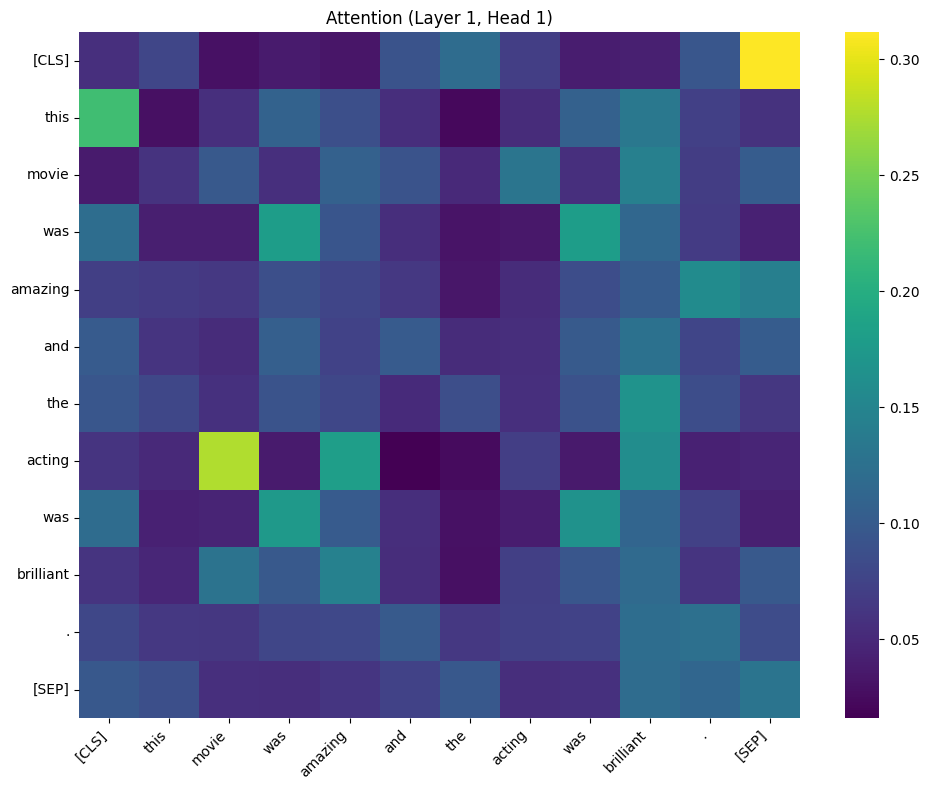

In [ ]:
visualize_attention(
    "This movie was amazing and the acting was brilliant.",
    layer=0,
    head=0
)